In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib, warnings, pickle, json, re
import seaborn as sns
from statistics import mean
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (20,10)

1. Data Cleaning and processing

In [4]:
# Price is in indian rupees
df_1 = pd.read_csv('bengaluru_house_prices.csv')
df_1.head(10)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170,2.0,1.0,38.00
6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,NaN,1310,3.0,1.0,63.25
9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00


In [5]:
df_nulls = pd.DataFrame(df_1.isnull().sum(), columns=['null_values'])
df_nulls['null_perce'] = [(x/len(df_1)*100) for x in df_nulls['null_values']]
df_nulls

,null_values,null_perce
area_type,0,0.000000
availability,0,0.000000
location,1,0.007508
size,16,0.120120
society,5502,41.306306
total_sqft,0,0.000000
bath,73,0.548048
balcony,609,4.572072
price,0,0.000000


In [10]:
df_1.dtypes

area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object

- We are going to remove all the society column, there are many null values and is difficult to work with it
- We will to remove the null location row
- The bath, balcony and size null values we are going to replace with the average values

In [6]:
df_1.drop('society', axis=1, inplace=True)
df_1.drop(df_1[df_1['location'].isnull()].index[0], axis=0, inplace=True)
df_1['bath'].replace(np.nan, round(df_1['bath'].mean()), inplace=True)
df_1['balcony'].replace(np.nan, round(df_1['balcony'].mean()), inplace=True)

In [9]:
size_mean = mean([int(re.search(r'\d+', i).group()) for i in df_1[df_1['size'].notnull()]['size']])
df_1['size'].replace(np.nan, '{} BHK'.format(round(size_mean)), inplace=True)

In [10]:
df_1.isnull().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

- To area_type we are going to assign a number label to each type
- To availability we are going to put 1 to Ready to Move and Immediate Possession and 0 for other
- Get the integer to size
- Get the total_sqft values, some are ranges values (A-B)

In [11]:
df_1.head(10)

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,1170,2.0,1.0,38.00
6,Super built-up Area,18-May,Old Airport Road,4 BHK,2732,4.0,2.0,204.00
7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,3300,4.0,2.0,600.00
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,1310,3.0,1.0,63.25
9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,1020,6.0,2.0,370.00


In [12]:
# Area type
df_1['area_type'] = df_1.area_type.astype('category')
df_1['area_type_cat'] = df_1['area_type'].cat.codes


In [13]:
df_1[['area_type', 'area_type_cat']]

,area_type,area_type_cat
0,Super built-up Area,3
1,Plot Area,2
2,Built-up Area,0
3,Super built-up Area,3
4,Super built-up Area,3
...,...,...
13315,Built-up Area,0
13316,Super built-up Area,3
13317,Built-up Area,0
13318,Super built-up Area,3


In [14]:
area_types = pd.DataFrame(df_1['area_type'].cat.categories)

In [15]:
# Viability
df_1['availability'] = df_1['availability'].replace('Ready To Move', 1)
df_1['availability'] = df_1['availability'].replace('Immediate Possession', 1)
for i in df_1['availability'].value_counts()[1:].index.tolist():
    df_1['availability'] = df_1['availability'].replace(i, 0)

In [16]:
# Size - get the integers
df_1['size'] = [int(i[0]) for i in df_1['size']]

In [17]:
# Total sqft cleaning data
def isfloat(x):
    try:
        float(x)
        return True
    except:
        return False

In [18]:
def sqft_cleaning(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return x

In [19]:
df_1['total_sqft'] = df_1['total_sqft'].apply(sqft_cleaning)

In [20]:
df_1 = df_1[df_1['total_sqft'].apply(isfloat)]

In [21]:
df_1.head(10)

,area_type,availability,location,size,total_sqft,bath,balcony,price,area_type_cat
0,Super built-up Area,0,Electronic City Phase II,2,1056.0,2.0,1.0,39.07,3
1,Plot Area,1,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00,2
2,Built-up Area,1,Uttarahalli,3,1440.0,2.0,3.0,62.00,0
3,Super built-up Area,1,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00,3
4,Super built-up Area,1,Kothanur,2,1200.0,2.0,1.0,51.00,3
5,Super built-up Area,1,Whitefield,2,1170.0,2.0,1.0,38.00,3
6,Super built-up Area,0,Old Airport Road,4,2732.0,4.0,2.0,204.00,3
7,Super built-up Area,1,Rajaji Nagar,4,3300.0,4.0,2.0,600.00,3
8,Super built-up Area,1,Marathahalli,3,1310.0,3.0,1.0,63.25,3
9,Plot Area,1,Gandhi Bazar,6,1020.0,6.0,2.0,370.00,2


2. Feature Engineering

In [22]:
df_1['price_per_sqft'] = df_1['price']*100000/df_1['total_sqft']

- We are going to reduce all the different locations, we keep the locations with more occurrences

In [23]:
df_1['location'] = df_1['location'].apply(lambda x: x.strip())
len(df_1.location.unique())

1288

In [40]:
df_locations = pd.DataFrame(df_1['location'].value_counts().reset_index())
less_locations = df_locations[df_locations['count'] <= 10]
df_1['location'] = ['other' if x in less_locations.location.to_list() else x for x in df_1['location']]

In [41]:
len(df_1.location.unique())

241

In [27]:
df_1.head(10)

,area_type,availability,location,size,total_sqft,bath,balcony,price,area_type_cat,price_per_sqft
0,Super built-up Area,0,Electronic City Phase II,2,1056.0,2.0,1.0,39.07,3,3699.810606
1,Plot Area,1,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00,2,4615.384615
2,Built-up Area,1,Uttarahalli,3,1440.0,2.0,3.0,62.00,0,4305.555556
3,Super built-up Area,1,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00,3,6245.890861
4,Super built-up Area,1,Kothanur,2,1200.0,2.0,1.0,51.00,3,4250.0
5,Super built-up Area,1,Whitefield,2,1170.0,2.0,1.0,38.00,3,3247.863248
6,Super built-up Area,0,Old Airport Road,4,2732.0,4.0,2.0,204.00,3,7467.057101
7,Super built-up Area,1,Rajaji Nagar,4,3300.0,4.0,2.0,600.00,3,18181.818182
8,Super built-up Area,1,Marathahalli,3,1310.0,3.0,1.0,63.25,3,4828.244275
9,Plot Area,1,Gandhi Bazar,6,1020.0,6.0,2.0,370.00,2,36274.509804


In [42]:
df_1['location'] = df_1['location'].astype('category')
df_1['location_cat'] = df_1['location'].cat.codes

In [43]:
df_1[df_1['location'] == 'other']

,area_type,availability,location,size,total_sqft,bath,balcony,price,area_type_cat,price_per_sqft,location_cat
9,Plot Area,1,other,6,1020.0,6.0,2.0,370.00,2,36274.509804,240
18,Super built-up Area,1,other,3,2770.0,4.0,2.0,290.00,3,10469.314079,240
19,Super built-up Area,1,other,2,1100.0,2.0,2.0,48.00,3,4363.636364,240
25,Super built-up Area,0,other,3,1250.0,3.0,2.0,56.00,3,4480.0,240
42,Super built-up Area,1,other,1,600.0,1.0,0.0,38.00,3,6333.333333,240
...,...,...,...,...,...,...,...,...,...,...,...
13291,Plot Area,0,other,1,812.0,1.0,0.0,26.00,2,3201.970443,240
13292,Super built-up Area,0,other,3,1440.0,2.0,2.0,63.93,3,4439.583333,240
13302,Super built-up Area,1,other,2,1075.0,2.0,2.0,48.00,3,4465.116279,240
13306,Plot Area,1,other,4,1200.0,5.0,2.0,325.00,2,27083.333333,240


In [44]:
location_types = pd.DataFrame(df_1['location'].cat.categories)
location_types

,0
0,1st Block Jayanagar
1,1st Phase JP Nagar
2,2nd Phase Judicial Layout
3,2nd Stage Nagarbhavi
4,5th Block Hbr Layout
...,...
236,Yelahanka
237,Yelahanka New Town
238,Yelenahalli
239,Yeshwanthpur


3. Outlier analysis

- Here, we are going to try do a logical analysis to the data, and remove unusual data \
For example, we can think that a 300 sqft/bhk is a normal threshold, so we can check this analysis

In [45]:
df_1['sqft/bhk'] = df_1['total_sqft']/df_1['size']
df_1.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,area_type_cat,price_per_sqft,location_cat,sqft/bhk
0,Super built-up Area,0,Electronic City Phase II,2,1056.0,2.0,1.0,39.07,3,3699.810606,79,528.0
1,Plot Area,1,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00,2,4615.384615,60,650.0
2,Built-up Area,1,Uttarahalli,3,1440.0,2.0,3.0,62.00,0,4305.555556,225,480.0
3,Super built-up Area,1,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00,3,6245.890861,159,507.0
4,Super built-up Area,1,Kothanur,2,1200.0,2.0,1.0,51.00,3,4250.0,151,600.0


In [46]:
df_1[df_1['sqft/bhk'] < 300]

,area_type,availability,location,size,total_sqft,bath,balcony,price,area_type_cat,price_per_sqft,location_cat,sqft/bhk
9,Plot Area,1,other,6,1020.0,6.0,2.0,370.0,2,36274.509804,240,170.0
45,Plot Area,1,HSR Layout,8,600.0,9.0,2.0,200.0,2,33333.333333,93,75.0
58,Plot Area,1,Murugeshpalya,6,1407.0,4.0,1.0,150.0,2,10660.98081,171,234.5
68,Plot Area,1,Devarachikkanahalli,8,1350.0,7.0,0.0,85.0,2,6296.296296,70,168.75
70,Plot Area,1,other,3,500.0,3.0,2.0,100.0,2,20000.0,240,166.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
13277,Plot Area,1,other,7,1400.0,7.0,2.0,218.0,2,15571.428571,240,200.0
13279,Plot Area,1,other,6,1200.0,5.0,2.0,130.0,2,10833.333333,240,200.0
13281,Plot Area,1,Margondanahalli,5,1375.0,5.0,1.0,125.0,2,9090.909091,167,275.0
13303,Plot Area,1,Vidyaranyapura,5,774.0,5.0,3.0,70.0,2,9043.927649,229,154.8


In [47]:
# We are going to remove this outliers
print(df_1.shape)
df_1 = df_1[~(df_1['sqft/bhk'] < 300)]
print(df_1.shape)

(13273, 12)
(12545, 12)


- Other good analysis, is view the price/sqft, we will remove that data beyond and below one standard deviation, the prices of the house generally depend of the location of that house, so, we are going to do the analysis per location

In [48]:
def remove_pps_outlier(df):
    df_out = pd.DataFrame()
    for key, sub_df in df.groupby('location'):
        median = np.mean(sub_df['price_per_sqft'])
        std = np.std(sub_df['price_per_sqft'])
        df_selected = sub_df[(sub_df['price_per_sqft'] > (median - std)) & (sub_df['price_per_sqft'] > (median - std))]
        df_out = pd.concat([df_out, df_selected], ignore_index=True)
    return df_out

In [49]:
print(df_1.shape)
df_1 = remove_pps_outlier(df=df_1)
print(df_1.shape)

(12545, 12)
(11747, 12)


- Now, we are going to check per location that houses that have equal price/sqft but have less bhk than other, \
For example, we will remove those 2 bhk apartaments whose price/sqft is less than price/sqft of 1 bhk

In [50]:
def remove_bhk_outliers(df):
   exclude_indices=np.array([])
   for location,location_df in df.groupby('location'):
       bhk_stats = {}
       for bhk, bhk_df in location_df.groupby('size'):
           bhk_stats[bhk]= {
               'mean':np.mean(bhk_df.price_per_sqft),
               'std':np.std(bhk_df.price_per_sqft),
               'count': bhk_df.shape[0]
               }
       for bhk, bhk_df in location_df.groupby('size'):
           stats = bhk_stats.get(bhk-1)
           if stats and stats['count'] > 5:
               exclude_indices=np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
   return df.drop(exclude_indices,axis='index')

In [51]:
df_1 = remove_bhk_outliers(df_1)
df_1.shape

(8019, 12)

- The last outlier removal is view the number of bathrooms per size (rooms)

In [52]:
print(list(df_1['bath'].unique()))
df_1['bath'].value_counts()

[4.0, 3.0, 2.0, 5.0, 7.0, 1.0, 8.0, 6.0, 10.0, 11.0, 9.0, 40.0, 12.0, 14.0, 16.0, 15.0, 13.0, 18.0]


bath
2.0     4075
3.0     2044
4.0      777
1.0      646
5.0      279
6.0      117
7.0       32
8.0       20
9.0       10
10.0       6
12.0       3
16.0       2
13.0       2
11.0       2
14.0       1
15.0       1
40.0       1
18.0       1
Name: count, dtype: int64

We are going to remove those rows that have the number of baths major than number of size + 2

In [53]:
df_1 = df_1[df_1['bath'] < df_1['size'] + 2]
df_1.shape

(7866, 12)

In [54]:
df_1.reset_index(inplace=True, drop=True)

- We will to do a some graphics to detect some number outliers

In [55]:
df_model = df_1.drop(['price_per_sqft', 'sqft/bhk', 'area_type', 'location'], axis=1)
df_model['total_sqft'] = df_model['total_sqft'].astype('float')
df_model.head()

,availability,size,total_sqft,bath,balcony,price,area_type_cat,location_cat
0,0,4,2850.0,4.0,1.0,428.0,3,0
1,0,3,1630.0,3.0,2.0,194.0,3,0
2,1,3,1875.0,2.0,3.0,235.0,3,0
3,1,4,2400.0,4.0,2.0,450.0,2,0
4,0,3,1200.0,2.0,0.0,130.0,0,0


In [56]:
features_corr = list(df_model.columns)
features_corr.remove('price')

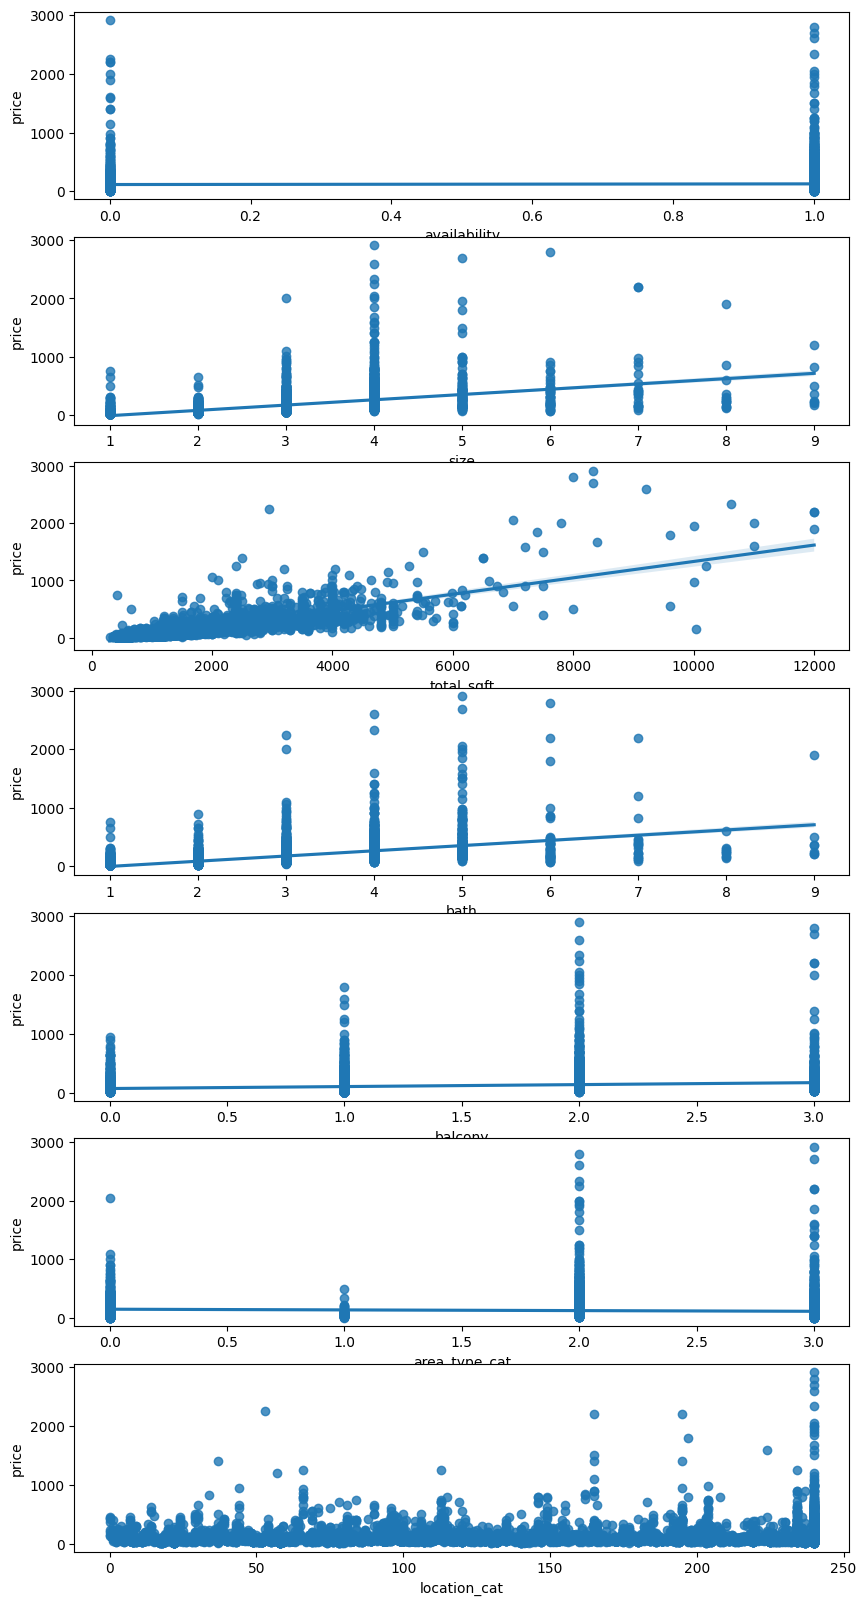

In [57]:
fig, axes = plt.subplots(len(features_corr), 1, figsize=(10,20))
for i in enumerate(features_corr):
    sns.regplot(x=i[1], y="price", data=df_model, ax=axes[i[0]])

In [58]:
df_model.corr()['price'].to_frame()

,price
availability,0.028053
size,0.538925
total_sqft,0.797725
bath,0.550275
balcony,0.161264
price,1.000000
area_type_cat,-0.082251
location_cat,0.167323


In [59]:
df_model['total_sqft'].describe()
mean_sqft = df_model['total_sqft'].describe()[1]
std_sqft = df_model['total_sqft'].describe()[2]

In [60]:
cut_off = std_sqft * 3
lower, upper = mean_sqft - cut_off, mean_sqft + cut_off

In [61]:
df_model.reset_index(inplace=True, drop=True)
outliers = [x for x in df_model['total_sqft'].index if df_model['total_sqft'][x] < lower or df_model['total_sqft'][x] > upper]

In [62]:
df_model.drop(outliers, axis=0, inplace=True)
df_1.drop(outliers, axis=0, inplace=True)

4. Model Building

In [63]:
X = df_model.drop('price', axis=1)
Y = df_model['price']

In [64]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10) 

- 4.1 Base model

In [65]:
lm_1 = LinearRegression()
lm_1.fit(x_train, y_train)
score_1 = round(lm_1.score(x_test, y_test) * 100, 2)
print(f"The score in a simple linear regression model is {score_1} %")

The score in a simple linear regression model is 60.24 %


In [66]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
f"The score with 10 splits in the dataset is {round(mean(cross_val_score(lm_1, X, Y, cv=cv)), 2) * 100}% " 

'The score with 10 splits in the dataset is 56.00000000000001% '

The scores are not successfully with base model. So, we are going to do a different technique with location feature, a Dummie strategy

- 4.2 Model With Location Dummies technique

In [67]:
df_1.drop(['location_cat'], axis=1, inplace=True)

In [68]:
dummies = pd.get_dummies(df_1['location'])

In [69]:
df_2 = pd.concat([df_1, dummies.drop('other', axis=1)], axis=1)
df_2.head(10)

,area_type,availability,location,size,total_sqft,bath,balcony,price,area_type_cat,price_per_sqft,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,Super built-up Area,0,1st Block Jayanagar,4,2850.0,4.0,1.0,428.0,3,15017.54386,...,False,False,False,False,False,False,False,False,False,False
1,Super built-up Area,0,1st Block Jayanagar,3,1630.0,3.0,2.0,194.0,3,11901.840491,...,False,False,False,False,False,False,False,False,False,False
2,Super built-up Area,1,1st Block Jayanagar,3,1875.0,2.0,3.0,235.0,3,12533.333333,...,False,False,False,False,False,False,False,False,False,False
3,Plot Area,1,1st Block Jayanagar,4,2400.0,4.0,2.0,450.0,2,18750.0,...,False,False,False,False,False,False,False,False,False,False
4,Built-up Area,0,1st Block Jayanagar,3,1200.0,2.0,0.0,130.0,0,10833.333333,...,False,False,False,False,False,False,False,False,False,False
5,Super built-up Area,0,1st Block Jayanagar,2,1235.0,2.0,2.0,148.0,3,11983.805668,...,False,False,False,False,False,False,False,False,False,False
6,Super built-up Area,0,1st Block Jayanagar,4,2750.0,4.0,0.0,413.0,3,15018.181818,...,False,False,False,False,False,False,False,False,False,False
7,Super built-up Area,0,1st Block Jayanagar,4,2450.0,4.0,2.0,368.0,3,15020.408163,...,False,False,False,False,False,False,False,False,False,False
8,Super built-up Area,1,1st Phase JP Nagar,3,1875.0,3.0,1.0,167.0,3,8906.666667,...,False,False,False,False,False,False,False,False,False,False
9,Built-up Area,1,1st Phase JP Nagar,5,1500.0,5.0,2.0,85.0,0,5666.666667,...,False,False,False,False,False,False,False,False,False,False


In [70]:
df_model_2 = df_2.drop(['price_per_sqft', 'sqft/bhk', 'area_type', 'location'], axis=1)
df_model_2.head()

,availability,size,total_sqft,bath,balcony,price,area_type_cat,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,0,4,2850.0,4.0,1.0,428.0,3,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,3,1630.0,3.0,2.0,194.0,3,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,3,1875.0,2.0,3.0,235.0,3,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,4,2400.0,4.0,2.0,450.0,2,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,3,1200.0,2.0,0.0,130.0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [71]:
X = df_model_2.drop('price', axis=1)
Y = df_model_2['price']

In [72]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=10, test_size=0.2) 

In [73]:
lm_2 = LinearRegression()
lm_2.fit(x_train, y_train)
score_2 = round(lm_2.score(x_test, y_test) * 100, 2)
print(f"The base score in a simple linear regression model with Dummie technique in Location is {score_2} %")

The base score in a simple linear regression model with Dummie technique in Location is 69.19 %


In [74]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
f"The score with 10 splits in the dataset is {round(mean(cross_val_score(lm_2, X, Y, cv=cv)), 2) * 100}% " 

'The score with 10 splits in the dataset is 65.0% '

The base score still is not to much successfully, we are going to try less features in the dataset

- 4.3 Model with less features

In [75]:
df_model_3 = df_2.drop(['price_per_sqft', 'sqft/bhk', 'area_type', 'location'], axis=1)
df_model_3.head()

,availability,size,total_sqft,bath,balcony,price,area_type_cat,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,0,4,2850.0,4.0,1.0,428.0,3,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,3,1630.0,3.0,2.0,194.0,3,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,3,1875.0,2.0,3.0,235.0,3,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,4,2400.0,4.0,2.0,450.0,2,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,3,1200.0,2.0,0.0,130.0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [76]:
df_model_3 = df_model_3.drop(['availability', 'balcony', 'area_type_cat'], axis=1)
df_model_3.head()

,size,total_sqft,bath,price,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,4,2850.0,4.0,428.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3,1630.0,3.0,194.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,1875.0,2.0,235.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,2400.0,4.0,450.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3,1200.0,2.0,130.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [77]:
features_corr = list(df_model_3.columns)
features_corr.remove('price')
features_corr[0:3]

['size', 'total_sqft', 'bath']

In [78]:
df_model_3['bath'] = df_model_3['bath'].astype('int') 
df_model_3['bath'].unique()

array([4, 3, 2, 5, 1, 6, 8, 7, 9])

In [79]:
X = df_model_3.drop('price', axis=1)
Y = df_model_3['price']

In [80]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=10, test_size=0.2) 

In [82]:
lm_3 = LinearRegression()
lm_3.fit(x_train, y_train)
score_3 = round(lm_3.score(x_test, y_test) * 100, 2)
print(f"The base score in a simple linear regression model is {score_3} %")

The base score in a simple linear regression model is 68.76 %


In [83]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
f"The score with 10 splits in the dataset is {round(mean(cross_val_score(lm_3, X, Y, cv=cv)), 2) * 100}% " 

'The score with 10 splits in the dataset is 65.0% '

In [84]:
Input= [('scale', StandardScaler()), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)
print(f"The score in a linear regression model with Standard Scaler is {round(pipe.score(x_test, y_test) * 100, 2)} %")

The score in a linear regression model with Standard Scaler is 68.76 %


We are going to choose the third model like the base model, because is more simple than the second and the score is not so different

In [85]:
yhat_test = lm_3.predict(x_test)

Text(0, 0.5, 'Proportion of Houses')

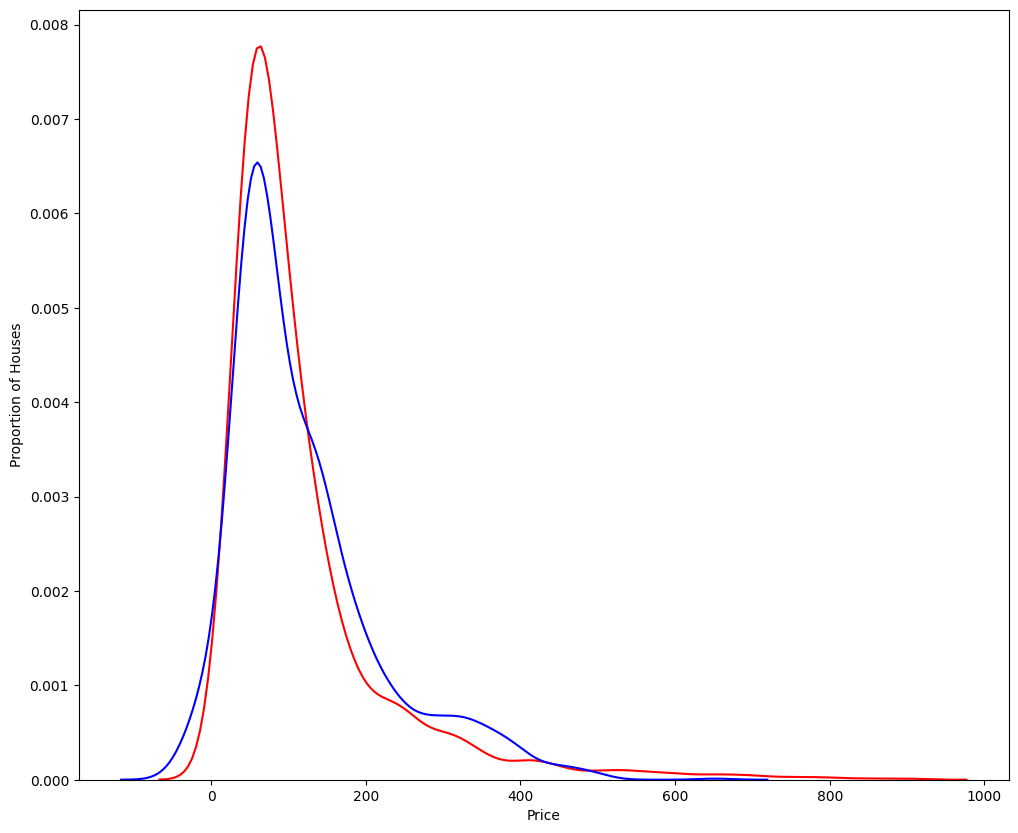

In [86]:
plt.figure(figsize=(12, 10))
ax1 = sns.distplot(y_test, hist=False, color="r", label='Actual values')
ax2 = sns.distplot(yhat_test, hist=False, color="b", label='Prediction', ax=ax1)
plt.xlabel('Price')
plt.ylabel('Proportion of Houses')


I a good approach of the real behavior (Good generalization)  

5. Regularization models

In [87]:
parameters1 = [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
rige_model = Ridge()
grid_1 = GridSearchCV(rige_model, parameters1, cv=4)
grid_1.fit(x_train, y_train)
best_estimator=grid_1.best_estimator_
print('The best estimator is with', best_estimator, 'with a score of', round(best_estimator.score(x_test, y_test),3) * 100, 'percent')

The best estimator is with Ridge(alpha=1) with a score of 68.60000000000001 percent


In [88]:
parameters1 = [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000], 'selection': ['random', 'cyclic']}]
lasso_model = Lasso()
grid_2 = GridSearchCV(lasso_model, parameters1, cv=4)
grid_2.fit(x_train, y_train)
best_estimator=grid_2.best_estimator_
print('The best estimator is with', best_estimator, 'with a score of', round(best_estimator.score(x_test, y_test),3) * 100, 'percent')

The best estimator is with Lasso(alpha=0.001) with a score of 68.7 percent


We don´t see any major improvements in the model

6. We are going to evaluate other regression models

In [89]:
regr = DecisionTreeRegressor(max_depth=5)
regr.fit(x_train, y_train)
score_tree = regr.score(x_test, y_test)
print(f"The score in a Decision Tree Regressor Model is {round(score_tree * 100, 2)} %")

The score in a Decision Tree Regressor Model is 64.73 %


In [90]:
regr = DecisionTreeRegressor(max_depth=5)
parameters = [{'criterion': ['mse', 'friedman_mse'], 'splitter': ['best', 'random']}]
grid_3 = GridSearchCV(regr, parameters, cv=5)
grid_3.fit(x_train, y_train)
best_estimator_3 = grid_3.best_estimator_
print('The best estimator is with', best_estimator_3, 'with a score of', round(best_estimator_3.score(x_test, y_test),3) * 100, 'percent')

The best estimator is with DecisionTreeRegressor(criterion='friedman_mse', max_depth=5) with a score of 64.7 percent


In [91]:
rfr = RandomForestRegressor(max_depth=7)
rfr.fit(x_train, y_train)
score_rfr = rfr.score(x_test, y_test)
print(f"The score in a Random Forest Regressor Model is {round(score_rfr * 100, 2)} %")

The score in a Random Forest Regressor Model is 69.68 %


In [92]:
rfr = RandomForestRegressor(max_depth=7)
parameters = [{'n_estimators': [2, 10, 30, 70, 100]}]
grid_4 = GridSearchCV(rfr, parameters, cv=5)
grid_4.fit(x_train, y_train)
best_estimator_3 = grid_4.best_estimator_
print('The best estimator is with', best_estimator_3, 'with a score of', round(best_estimator_3.score(x_test, y_test),3) * 100, 'percent')

The best estimator is with RandomForestRegressor(max_depth=7, n_estimators=70) with a score of 70.1 percent


Finally, we conclude that the best model for now is a Linear Model with a Dummies Technique in location and less features than the original

7. Make some predictions

In [93]:
X = df_model_3.drop('price', axis=1)
Y = df_model_3['price']

In [94]:
df_model_3.columns

Index(['size', 'total_sqft', 'bath', 'price', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [95]:
def price_prediction(size, sqft, baths, location):
    loc_index = np.where(X.columns==location)[0] # Here, we check if the location exist in the columns of the resulting data set
    
    x = np.zeros(len(X.columns)) # We create the array to insert in the model
    x[0] = size
    x[1] = sqft
    x[2] = baths
    if loc_index >= 0: # If the location exist, we put 1 in their corresponding column
        x[loc_index] = 1
    
    return lm_3.predict([x])[0]

In [103]:
price_prediction(2, 1000, 2, '1st Block Jayanagar')

167.7752564927797

8. Save the model

In [104]:
with open('model.pickle', 'wb') as model:
    pickle.dump(lm_3, model)

In [99]:
columns = {'columns_models' : [col.lower() for col in X.columns]}
with open('columns_model.json', 'w') as cols:
    cols.write(json.dumps(columns))